In [ ]:
import os
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
import cv2
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, AvgPool2D
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data_dir = '/content/CNN_dataset'

# Define the path to the zipped folder in your Drive
zip_path = '/content/drive/MyDrive/Dataset/CNN_dataset.zip'

# Define the path where you want to extract the contents of the zip file
extract_path = '/content/drive/MyDrive/Dataset'

# Unzip the folder using the !unzip command
!unzip '{zip_path}' -d '{extract_path}'

In [ ]:
data_dir = '/content/drive/MyDrive/Dataset/CNN_dataset'

# Get the names of the subdirectories in the data directory
categories = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))

# Count the number of subdirectories (i.e., categories)
total_categories = len(categories)

# Create a list of image file paths for each category
img_per_category = [sorted(os.listdir(os.path.join(data_dir, categories[i]))) for i in range(total_categories)]

# Count the number of images in each category
img_per_category_count = [len(img_per_category[i]) for i in range(total_categories)]

# Combine all the image file paths into a single list
image_file = [os.path.join(data_dir, categories[i], x) for i in range(total_categories) for x in img_per_category[i]]

# Create a list of image categories, where each element corresponds to the category of the corresponding image file in image_file_list
image_category = [i for i in range(total_categories) for _ in img_per_category[i]]

# Count the total number of images
total_image_count = len(image_file)

# Get the dimensions of the first image in the list (assuming all images have the same dimensions)
dimension = PIL.Image.open(image_file[0]).size

# Print some information about the data
print("Dimension", dimension)
print("Categories", categories)
print("Images per category", img_per_category_count)


Dimension (64, 64)
Categories ['AbdomenCT', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Images per category [10000, 10000, 10000, 10000, 10000]


In [ ]:
image_list = []
for image_path in image_file:
  image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  image_list.append(image)

In [ ]:
# convert image_list and image_category to numpy arrays
image_list = np.array(image_list)
image_category = np.array(image_category)

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(image_list, image_category, 
                                                    test_size=0.1, 
                                                    stratify=image_category, 
                                                    random_state=42)

# Split train data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.1/(1-0.1), 
                                                  stratify=y_train, 
                                                  random_state=42)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (40000, 64, 64)
y_train shape: (40000,)
x_val shape: (5000, 64, 64)
y_val shape: (5000,)
x_test shape: (5000, 64, 64)
y_test shape: (5000,)


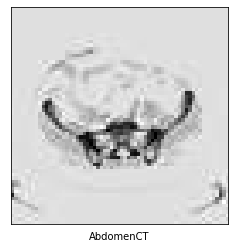

In [ ]:
plt.xticks([])
plt.yticks([])
plt.xlabel(categories[y_train[903]])
plt.imshow(x_train[903],cmap=plt.cm.binary)

In [56]:
model = tf.keras.Sequential()
# Must define the input shape in the first layer of the neural network
model.add(Conv2D(filters=64, kernel_size=(3,3),strides=(1, 1), padding='same', activation='relu', input_shape=(64,64,1))) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(filters=32, kernel_size=(3,3),strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=16, kernel_size=(3,3),strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
# Take a look at the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 32)       

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_log=model.fit(x_train, y_train,
          batch_size=100,
          epochs=10,
          verbose=1,
          validation_split=.3)

Epoch 1/10
280/280 [==============================] - 207s 738ms/step - loss: 0.1491 - accuracy: 0.9463 - val_loss: 0.0289 - val_accuracy: 0.9921
Epoch 2/10
280/280 [==============================] - 207s 740ms/step - loss: 0.0663 - accuracy: 0.9783 - val_loss: 0.0181 - val_accuracy: 0.9948
Epoch 3/10
280/280 [==============================] - 207s 740ms/step - loss: 0.0386 - accuracy: 0.9872 - val_loss: 0.0171 - val_accuracy: 0.9942
Epoch 4/10
280/280 [==============================] - 203s 727ms/step - loss: 0.0329 - accuracy: 0.9889 - val_loss: 0.0132 - val_accuracy: 0.9958
Epoch 5/10
280/280 [==============================] - 203s 724ms/step - loss: 0.0248 - accuracy: 0.9917 - val_loss: 0.0104 - val_accuracy: 0.9959
Epoch 6/10
280/280 [==============================] - 202s 722ms/step - loss: 0.0235 - accuracy: 0.9921 - val_loss: 0.0144 - val_accuracy: 0.9976
Epoch 7/10
280/280 [==============================] - 202s 723ms/step - loss: 0.0182 - accuracy: 0.9936 - val_loss: 0.0081 -

In [ ]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9990000128746033


In [ ]:
predictions = model.predict(x_test)
predictions[0]

157/157 [==============================] - 9s 54ms/step


array([1.2568386e-04, 8.8816392e-05, 9.9955189e-01, 1.1046122e-05,
       2.2257534e-04, 6.1205380e-10, 2.6282089e-08, 1.8807771e-08,
       1.9698414e-09, 3.3859040e-09], dtype=float32)

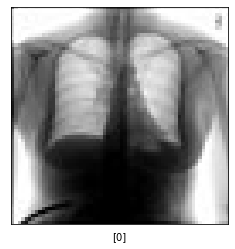

In [ ]:
# Show one of the images from the test dataset
plt.xticks([])
plt.yticks([])
plt.xlabel([y_train[33]])
plt.imshow(x_test[33],cmap=plt.cm.binary)

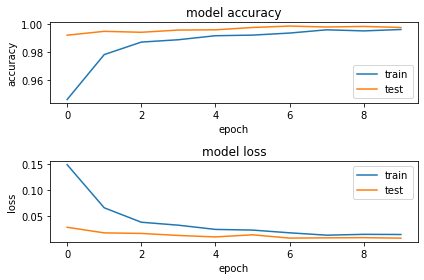

In [ ]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['accuracy'])
plt.plot(model_log.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()